<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-filip-martin/blob/main/Noise_recognition_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se zvukovými daty lze pracovat buď na základě "raw waveform" nebo na základě spectogramu. Spectogram se zde jevé jako lepší.

Následující kód vytáhne data ze složky data a zobrazí jejich spectogramy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Processing file: -10VpRpg3e4.flac


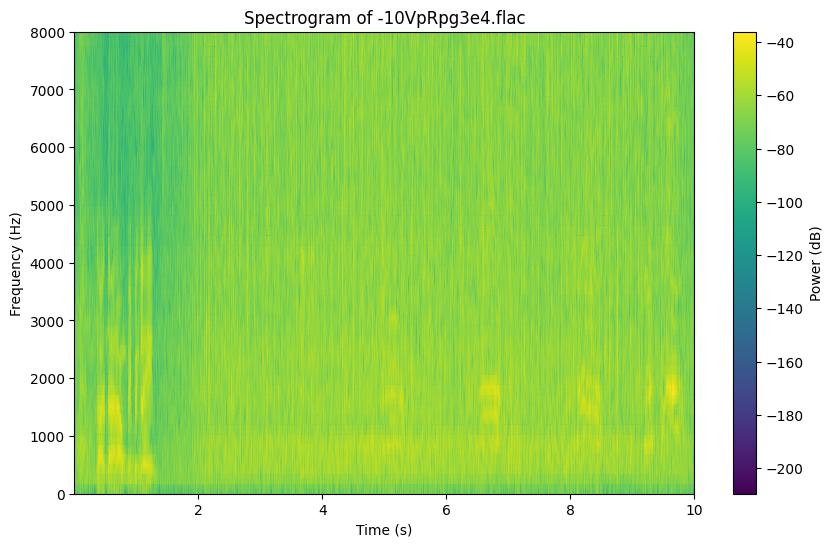

Processing file: --SeOZy3Yik.flac


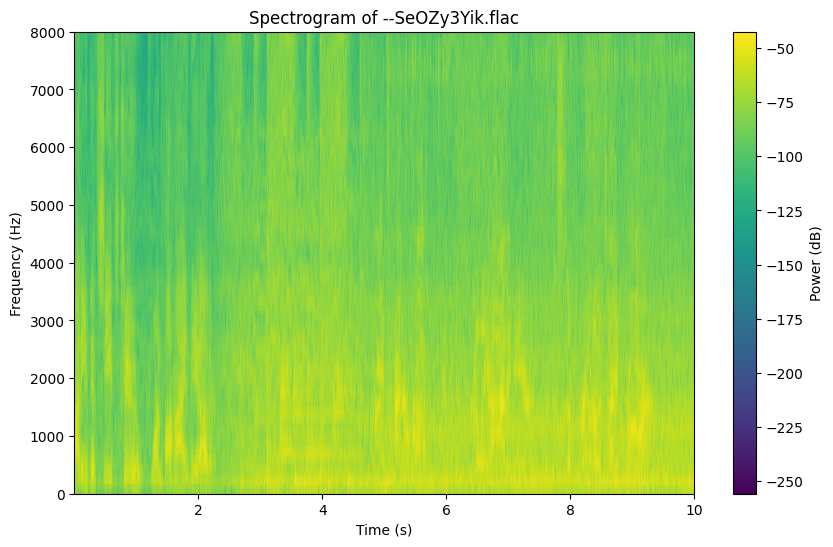

Processing file: -3qGt7eDqMU.flac


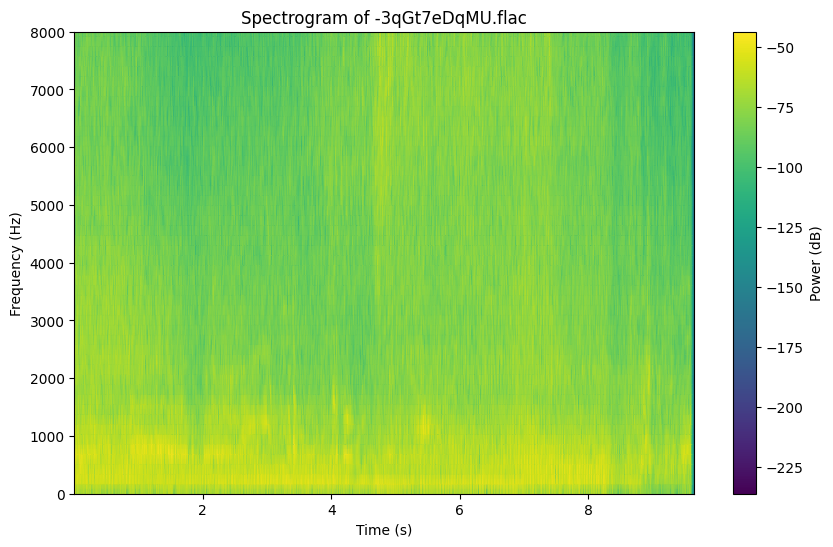

Processing file: --byNAHo7tQ.flac


<ipython-input-2-cc4aedbb5949>:31: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')


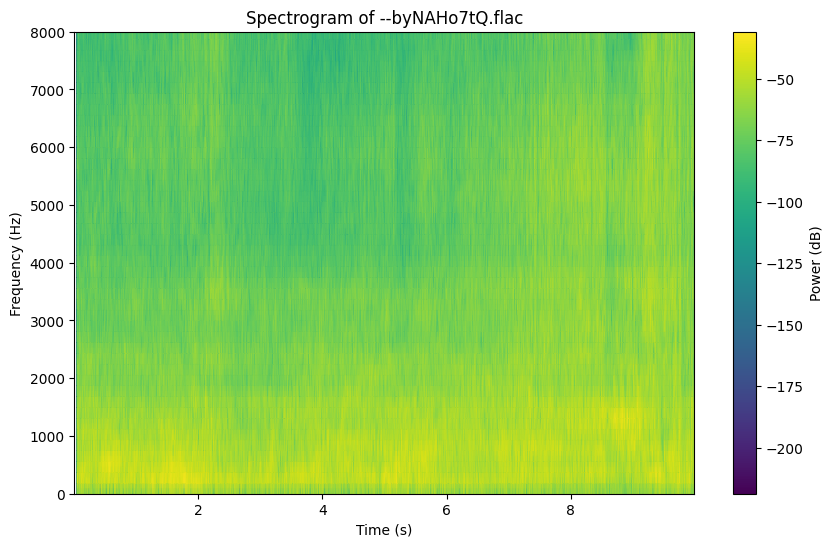

Processing file: --EG-JqO4S0.flac


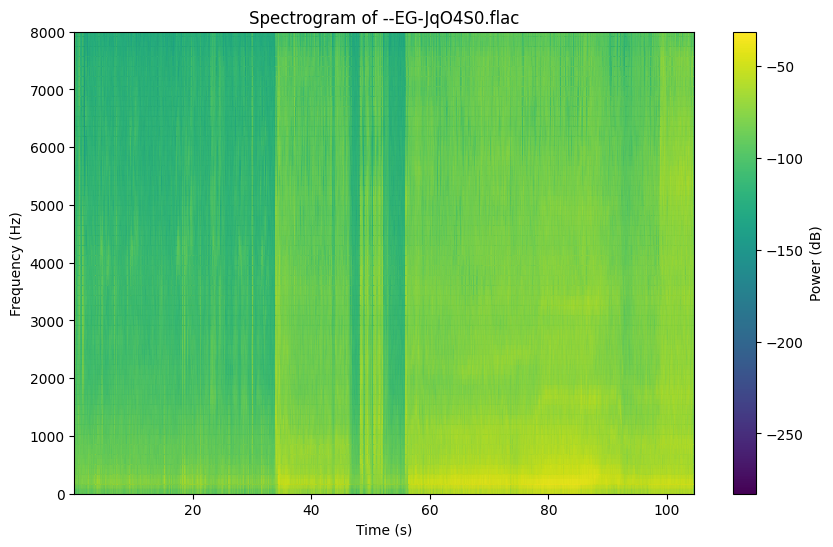

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import soundfile as sf

data_folder = "./data"


def generate_and_plot_spectrogram(file_path):
    try:
        # Read audio file
        data, sample_rate = sf.read(file_path)

        # If stereo, convert to mono
        if len(data.shape) > 1:
            data = np.mean(data, axis=1)

        # Compute the spectrogram
        frequencies, times, Sxx = spectrogram(data, fs=sample_rate)

        # Plot the spectrogram
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
        plt.colorbar(label='Power (dB)')
        plt.title(f'Spectrogram of {os.path.basename(file_path)}')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.ylim(0, 8000)  # Human hearing range (0-8kHz)
        plt.show()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Process and plot all files in the data folder
audio_extensions = (".flac")

for file in os.listdir(data_folder):
    if file.endswith(audio_extensions):
        file_path = os.path.join(data_folder, file)
        generate_and_plot_spectrogram(file_path)


Následující kód nad histogrami tvoří konvoluční síť a využívá ji pro klasifikaci.

Data očekává ve formátu .flac ve složce data, rozdělené do podsložek podle názvu labelu.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from scipy.signal import spectrogram
import soundfile as sf
import matplotlib.pyplot as plt

# --- Step 1: Define a Custom Data Generator ---
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, num_classes, input_size=(128, 128)):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.input_size = input_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files, batch_labels)
        return X, y

    def __data_generation(self, batch_files, batch_labels):
        X = np.zeros((len(batch_files), *self.input_size, 1), dtype=np.float32)
        y = np.zeros((len(batch_labels), self.num_classes), dtype=np.float32)

        for i, file_path in enumerate(batch_files):
            # Load audio and generate spectrogram
            data, sample_rate = sf.read(file_path)
            if len(data.shape) > 1:
                data = np.mean(data, axis=1)  # Convert to mono
            frequencies, times, Sxx = spectrogram(data, fs=sample_rate)

            # Resize spectrogram to input size
            spectrogram_image = np.log1p(Sxx)
            spectrogram_image = np.resize(spectrogram_image, self.input_size)
            X[i, :, :, 0] = spectrogram_image  # Add channel dimension

            # One-hot encode labels
            y[i, batch_labels[i]] = 1.0

        return X, y

# --- Step 2: Load Data and Labels ---
data_folder = "./data"
labels = {"engine": 0, "speech": 1, "music": 2}

file_paths = []
file_labels = []
for class_name, label in labels.items():
    class_folder = os.path.join(data_folder, class_name)
    for file in os.listdir(class_folder):
        if file.endswith(".flac"):
            file_paths.append(os.path.join(class_folder, file))
            file_labels.append(label)

# Shuffle data
data = list(zip(file_paths, file_labels))
np.random.shuffle(data)
file_paths, file_labels = zip(*data)

# Split into train and validation sets
split_index = int(len(file_paths) * 0.8)
train_files, val_files = file_paths[:split_index], file_paths[split_index:]
train_labels, val_labels = file_labels[:split_index], file_labels[split_index:]

# --- Step 3: Initialize Data Generators ---
batch_size = 16
input_size = (128, 128)
num_classes = len(labels)

train_generator = AudioDataGenerator(train_files, train_labels, batch_size, num_classes, input_size)
val_generator = AudioDataGenerator(val_files, val_labels, batch_size, num_classes, input_size)

# --- Step 4: Build the CNN Model ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*input_size, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Step 5: Train the Model ---
epochs = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

# --- Step 6: Plot Training History ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- Optional: Save the Model ---
model.save("flac_cnn_classifier.h5")
print("Model saved as 'flac_cnn_classifier.h5'")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.3293 - loss: 1.1001 - val_accuracy: 0.3500 - val_loss: 1.0985
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.3238 - loss: 1.0987 - val_accuracy: 0.3500 - val_loss: 1.0985
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.2966 - loss: 1.0989 - val_accuracy: 0.3278 - val_loss: 1.0987
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3548 - loss: 1.0987 - val_accuracy: 0.3222 - val_loss: 1.0988
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3304 - loss: 1.0986 - val_accuracy: 0.3278 - val_loss: 1.0988
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.3334 - loss: 1.0988 - val_accuracy: 0.3222 - val_loss: 1.0989
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.3467 - loss: 1.0987 - val_accuracy: 0.3278 - val_loss: 1.0988
Epoch 8/10


KeyboardInterrupt: 

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from scipy.signal import spectrogram
import soundfile as sf
import matplotlib.pyplot as plt

# --- Step 1: Define a Custom Data Generator ---
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, num_classes, input_size=(128, 128)):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.input_size = input_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files, batch_labels)
        return X, y

    def __data_generation(self, batch_files, batch_labels):
        X = np.zeros((len(batch_files), *self.input_size, 1), dtype=np.float32)
        y = np.zeros((len(batch_labels), self.num_classes), dtype=np.float32)

        for i, file_path in enumerate(batch_files):
            # Load audio and generate spectrogram
            data, sample_rate = sf.read(file_path)
            if len(data.shape) > 1:
                data = np.mean(data, axis=1)  # Convert to mono
            frequencies, times, Sxx = spectrogram(data, fs=sample_rate)

            # Resize spectrogram to input size
            spectrogram_image = np.log1p(Sxx)
            spectrogram_image = np.resize(spectrogram_image, self.input_size)
            X[i, :, :, 0] = spectrogram_image  # Add channel dimension

            # One-hot encode labels
            y[i, batch_labels[i]] = 1.0

        return X, y

# --- Step 2: Load Data and Labels ---
data_folder = "./data"
labels = {"engine": 0, "speech": 1, "music": 2}

file_paths = []
file_labels = []
for class_name, label in labels.items():
    class_folder = os.path.join(data_folder, class_name)
    for file in os.listdir(class_folder):
        if file.endswith(".flac"):
            file_paths.append(os.path.join(class_folder, file))
            file_labels.append(label)

# Shuffle data
data = list(zip(file_paths, file_labels))
np.random.shuffle(data)
file_paths, file_labels = zip(*data)

# Split into train and validation sets
split_index = int(len(file_paths) * 0.8)
train_files, val_files = file_paths[:split_index], file_paths[split_index:]
train_labels, val_labels = file_labels[:split_index], file_labels[split_index:]

# --- Step 3: Initialize Data Generators ---
batch_size = 16
input_size = (128, 128)
num_classes = len(labels)

train_generator = AudioDataGenerator(train_files, train_labels, batch_size, num_classes, input_size)
val_generator = AudioDataGenerator(val_files, val_labels, batch_size, num_classes, input_size)

# --- Step 4: Build the CNN Model ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*input_size, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Step 5: Train the Model ---
epochs = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

# --- Step 6: Plot Training History ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- Optional: Save the Model ---
model.save("flac_cnn_classifier.h5")
print("Model saved as 'flac_cnn_classifier.h5'")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 30, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 256)         │         590,0

 Total params: 3,536,867 (13.49 MB)

 Trainable params: 3,534,435 (13.48 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.3937 - loss: 1.7003 - val_accuracy: 0.3389 - val_loss: 1.2511
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.5004 - loss: 1.3418 - val_accuracy: 0.3389 - val_loss: 1.5041
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.5699 - loss: 1.1453 - val_accuracy: 0.3389 - val_loss: 1.5027
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.6280 - loss: 0.9678 - val_accuracy: 0.3389 - val_loss: 2.1776
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.6379 - loss: 0.9211 - val_accuracy: 0.3389 - val_loss: 2.4261
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.6340 - loss: 0.9381 - val_accuracy: 0.3389 - val_loss: 3.4811
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.6938 - loss: 0.8217 - val_accuracy: 0.3389 - val_loss: 4.0297
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step - accuracy: 0.7146 - loss: 0.6941 - val_accuracy: 0.3389 - v

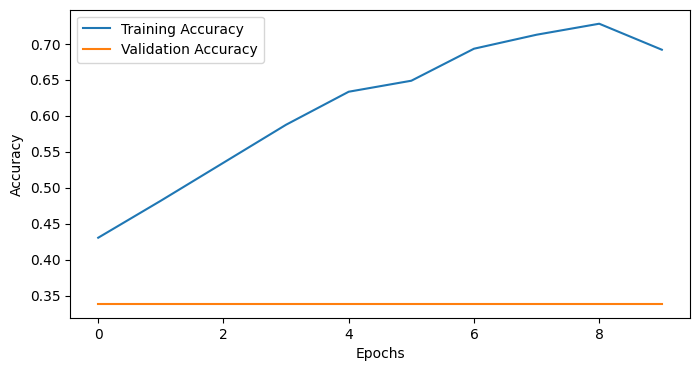

Model saved as 'flac_cnn_classifier_updated.h5'


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from scipy.signal import spectrogram
import soundfile as sf
import matplotlib.pyplot as plt

# --- Step 1: Define a Custom Data Generator ---
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, num_classes, input_size=(128, 128)):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.input_size = input_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files, batch_labels)
        return X, y

    def __data_generation(self, batch_files, batch_labels):
        X = np.zeros((len(batch_files), *self.input_size, 1), dtype=np.float32)
        y = np.zeros((len(batch_labels), self.num_classes), dtype=np.float32)

        for i, file_path in enumerate(batch_files):
            # Load audio and generate spectrogram
            data, sample_rate = sf.read(file_path)
            if len(data.shape) > 1:
                data = np.mean(data, axis=1)  # Convert to mono
            frequencies, times, Sxx = spectrogram(data, fs=sample_rate)

            # Resize spectrogram to input size
            spectrogram_image = np.log1p(Sxx)
            spectrogram_image = np.resize(spectrogram_image, self.input_size)
            X[i, :, :, 0] = spectrogram_image  # Add channel dimension

            # One-hot encode labels
            y[i, batch_labels[i]] = 1.0

        return X, y

# --- Step 2: Load Data and Labels ---
data_folder = "./data"
labels = {"engine": 0, "speech": 1, "music": 2}

file_paths = []
file_labels = []
for class_name, label in labels.items():
    class_folder = os.path.join(data_folder, class_name)
    for file in os.listdir(class_folder):
        if file.endswith(".flac"):
            file_paths.append(os.path.join(class_folder, file))
            file_labels.append(label)

# Shuffle data
data = list(zip(file_paths, file_labels))
np.random.shuffle(data)
file_paths, file_labels = zip(*data)

# Split into train and validation sets
split_index = int(len(file_paths) * 0.8)
train_files, val_files = file_paths[:split_index], file_paths[split_index:]
train_labels, val_labels = file_labels[:split_index], file_labels[split_index:]

# --- Step 3: Initialize Data Generators ---
batch_size = 16
input_size = (128, 128)
num_classes = len(labels)

train_generator = AudioDataGenerator(train_files, train_labels, batch_size, num_classes, input_size)
val_generator = AudioDataGenerator(val_files, val_labels, batch_size, num_classes, input_size)

# --- Step 4: Build the Updated CNN Model ---
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(*input_size, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 4
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model with reduced learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# --- Step 5: Train the Model ---
epochs = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

# --- Step 6: Plot Training History ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- Optional: Save the Model ---
model.save("flac_cnn_classifier_updated.h5")
print("Model saved as 'flac_cnn_classifier_updated.h5'")


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from scipy.signal import spectrogram
import soundfile as sf
import matplotlib.pyplot as plt

# --- Step 1: Define a Custom Data Generator ---
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, num_classes, input_size=(128, 128)):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.input_size = input_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files, batch_labels)
        return X, y

    def __data_generation(self, batch_files, batch_labels):
        X = np.zeros((len(batch_files), *self.input_size, 1), dtype=np.float32)
        y = np.zeros((len(batch_labels), self.num_classes), dtype=np.float32)

        for i, file_path in enumerate(batch_files):
            # Load audio and generate spectrogram
            data, sample_rate = sf.read(file_path)
            if len(data.shape) > 1:
                data = np.mean(data, axis=1)  # Convert to mono
            frequencies, times, Sxx = spectrogram(data, fs=sample_rate)

            # Resize spectrogram to input size
            spectrogram_image = np.log1p(Sxx)
            spectrogram_image = np.resize(spectrogram_image, self.input_size)
            X[i, :, :, 0] = spectrogram_image  # Add channel dimension

            # One-hot encode labels
            y[i, batch_labels[i]] = 1.0

        return X, y

# --- Step 2: Load Data and Labels ---
data_folder = "./data"
labels = {"engine": 0, "speech": 1, "music": 2}

file_paths = []
file_labels = []
for class_name, label in labels.items():
    class_folder = os.path.join(data_folder, class_name)
    for file in os.listdir(class_folder):
        if file.endswith(".flac"):
            file_paths.append(os.path.join(class_folder, file))
            file_labels.append(label)

# Shuffle data
data = list(zip(file_paths, file_labels))
np.random.shuffle(data)
file_paths, file_labels = zip(*data)

# Split into train and validation sets
split_index = int(len(file_paths) * 0.8)
train_files, val_files = file_paths[:split_index], file_paths[split_index:]
train_labels, val_labels = file_labels[:split_index], file_labels[split_index:]

# --- Step 3: Initialize Data Generators ---
batch_size = 16
input_size = (128, 128)
num_classes = len(labels)

train_generator = AudioDataGenerator(train_files, train_labels, batch_size, num_classes, input_size)
val_generator = AudioDataGenerator(val_files, val_labels, batch_size, num_classes, input_size)

# --- Step 4: Build the Updated CNN Model ---
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(*input_size, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Dropout after first block

    # Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Dropout after second block

    # Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),  # Dropout after third block

    # Block 4
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),  # Dropout after fourth block

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout before final classification
    layers.Dense(num_classes, activation='softmax')
])


# Compile the model with reduced learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# --- Step 5: Train the Model ---
epochs = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

# --- Step 6: Plot Training History ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- Optional: Save the Model ---
model.save("flac_cnn_classifier_updated.h5")
print("Model saved as 'flac_cnn_classifier_updated.h5'")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 30, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,536,867 (13.49 MB)

 Trainable params: 3,534,435 (13.48 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.3517 - loss: 1.8654 - val_accuracy: 0.3500 - val_loss: 1.1030
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.4071 - loss: 1.7184 - val_accuracy: 0.3500 - val_loss: 1.1346
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.4254 - loss: 1.4753 - val_accuracy: 0.2889 - val_loss: 1.2724
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.4640 - loss: 1.3508 - val_accuracy: 0.3500 - val_loss: 1.5066
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.4862 - loss: 1.3416 - val_accuracy: 0.3500 - val_loss: 1.8052
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.4661 - loss: 1.3600 - val_accuracy: 0.3500 - val_loss: 1.8742
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.4230 - loss: 1.4666 - val_accuracy: 0.3500 - val_loss: 2.0391
Epoch 8/10
42/45 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4924 - loss: 1.2864 

Klasifikace zvuku po jednotlivých sekundách, využívá výše naučenou síť flac_cnn_classifier.

Vstupní file rozpadne na jednotlivé sekundy, pro každou sekundu vypočítá histogram a následně he klasifikuje pomocí výše naučené sítě.



In [ ]:
import numpy as np
import soundfile as sf
from scipy.signal import spectrogram
import tensorflow as tf
import matplotlib.pyplot as plt

class AudioClassifier:
    def __init__(self, model_path, input_size=(128, 128)):
        """
        Initialize the audio classifier.
        :param model_path: Path to the trained CNN model.
        :param input_size: Size of spectrogram input for the model.
        """
        self.model = tf.keras.models.load_model(model_path)
        self.input_size = input_size

    def preprocess_chunk(self, audio_chunk, sample_rate):
        """
        Convert a 1-second audio chunk into a spectrogram and preprocess it.
        :param audio_chunk: Audio data (1 second of samples).
        :param sample_rate: Sample rate of the audio.
        :return: Preprocessed spectrogram.
        """
        _, _, Sxx = spectrogram(audio_chunk, fs=sample_rate)
        Sxx = np.log1p(Sxx)  # Log scaling for normalization
        Sxx_resized = np.resize(Sxx, self.input_size)  # Resize to model input size
        return Sxx_resized[..., np.newaxis]  # Add channel dimension

    def classify_audio(self, audio_path, chunk_duration=1.0):
        """
        Classify each second of audio into classes.
        :param audio_path: Path to the audio file.
        :param chunk_duration: Duration (in seconds) of each chunk.
        :return: List of predictions (one per chunk).
        """
        data, sample_rate = sf.read(audio_path)
        if len(data.shape) > 1:  # Convert to mono if stereo
            data = np.mean(data, axis=1)

        chunk_size = int(sample_rate * chunk_duration)  # Number of samples per chunk
        num_chunks = len(data) // chunk_size  # Total chunks in audio

        predictions = []
        for i in range(num_chunks):
            start = i * chunk_size
            end = start + chunk_size
            audio_chunk = data[start:end]

            # Preprocess chunk
            spectrogram_input = self.preprocess_chunk(audio_chunk, sample_rate)
            spectrogram_input = np.expand_dims(spectrogram_input, axis=0)  # Add batch dimension

            # Predict
            prediction = self.model.predict(spectrogram_input, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]
            predictions.append(predicted_class)
            print(f"Second {i + 1}: Class {predicted_class}")

        return predictions

# --- Example Usage ---

# Path to the trained model and audio file
model_path = "flac_cnn_classifier.h5"  # Trained CNN model
audio_path = "example.flac"  # Audio file to classify

# Initialize the classifier
classifier = AudioClassifier(model_path=model_path)

# Classify each second of the audio
predictions = classifier.classify_audio(audio_path)

# Display predictions
for i, pred in enumerate(predictions):
    print(f"Second {i + 1}: Class {pred}")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'flac_cnn_classifier.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)